# Set Up

In [1]:
%run SetUp.ipynb
%run Process_Data-wModule.ipynb

Home Directory = /home/cjpar/Work/wfe/wfey
Log Path = /home/cjpar/Work/wfe/wfey/logs/logs/
Home Directory = /home/cjpar/Work/wfe/wfey
Log Path = /home/cjpar/Work/wfe/wfey/logs/logs/


## Loading DataFrames

In [2]:
bm_output = pd.read_pickle(HOME_DIRECTORY+'/'+DF+'/'+LOGS+'_output.pkl')
bm_output_raw = pd.read_pickle(HOME_DIRECTORY+'/'+DF+'/'+LOGS+'_output_raw.pkl')

bm_output_clean = pd.read_pickle(HOME_DIRECTORY+'/'+DF+'/'+LOGS+'_output_clean.pkl')
bm_output_clean_raw = pd.read_pickle(HOME_DIRECTORY+'/'+DF+'/'+LOGS+'_output_clean_raw.pkl')

cols = bm_output_clean_raw.columns  ### ?NOTE -- would a different df change the columns - i dont think so

energy_regex = re.compile("energy.*_input")
energy_cols = list(filter(energy_regex.match, cols))

bm_start_index = list(cols).index("epThread")
bm_cols = list(cols[bm_start_index:])

#print("Energy Cols: ", energy_cols)
#print("BM Cols: ", bm_cols)
print("all columns: ", cols)

# Flatten the arrays 
## Time is no longer an element to consider with the module -- but perhaps with more event processors
## this will need to be exploded as well
#bm_energy_output_flat = bm_output.explode(energy_cols +["time"], ignore_index=True)
#bm_energy_output_flat_raw = bm_output_clean_raw.explode(energy_cols +["time"], ignore_index=True)

bm_perf_output_flat = bm_output.explode(bm_cols, ignore_index=True)
bm_perf_output_flat_raw = bm_output_clean_raw.explode(bm_cols, ignore_index=True)

#display(bm_output_raw)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(bm_output_flat_raw)

all columns:  Index(['KEY', 'configs', 'eventrate', 'eventprocCPUs', 'sourceCPUs',
       'latency_min', 'latency_max', 'latency_mean', 'epThread', 'ID', 'Core',
       'Start Energy', 'End Energy', 'Energy Diff', 'Total Wakeups',
       'Spurious Wakeups', 'Events', 'Active Cycles', 'Inactive Cycles',
       'Cycle Diff', 'CPU Cycles', 'Instructions Retired'],
      dtype='object')


## Graph Set-Up

In [3]:
sns.set_palette("Paired")
pd.options.mode.chained_assignment = None

eventsubset=[0, 10, 100, 1000, 100000]
#eventsubset=[0, 50000]
sourceCPUsubset=["1", "10", "50"]
#sourceCPUsubset=["1"]

#ENERGY_COLUMN='energy1_input'
ENERGY_COLUMN='Energy Diff' ## These graphs are made with the assumption that there is only one core in Energy Diff
                            ## Small changes needs to be made to accomadate choosing a specific core

def return_df(df):
    print("Event Rate subset: ", eventsubset)
    print("Source CPU subset: ", sourceCPUsubset)
    return df[ (df['eventrate'].isin(eventsubset)) & (df['sourceCPUs'].isin(sourceCPUsubset))].copy()

def return_config_set(df, event, scpu):
    return ( df[ (df['eventrate'] == event) & (df['sourceCPUs'] == scpu)] )

df_used = return_df(bm_output)

Event Rate subset:  [0, 10, 100, 1000, 100000]
Source CPU subset:  ['1', '10', '50']


# Graphs -- Overview

## Heat Map

### Events, Latency, & Subset of Event Cores

Event Rate subset:  [0, 10, 100, 1000, 100000]
Source CPU subset:  ['1', '10', '50']


<Axes: >

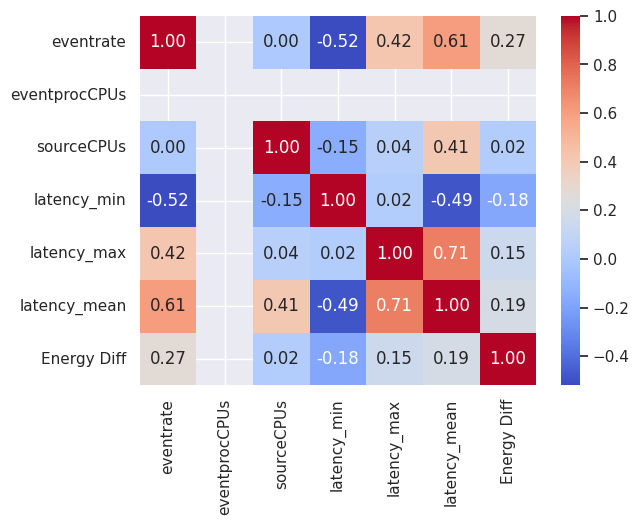

In [4]:
df_used = return_df(bm_perf_output_flat_raw)

common_cols = ['eventrate', 'eventprocCPUs', 'sourceCPUs', 'latency_min', 'latency_max', 'latency_mean']
output_cols = common_cols + [ENERGY_COLUMN]
corr = df_used[output_cols].corr()

#fig, ax = plt.subplots(figsize=(100, 100))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')

### Energy on All Cores

In [5]:
## NOTE -- this is insane dont load this
if energy_cols: # If energy gathering outside of benchmark was used
    df_used = return_df(bm_perf_output_flat_raw)
    
    common_cols = ['eventrate', 'eventprocCPUs', 'sourceCPUs', 'latency_min', 'latency_max', 'latency_mean']
    #output_cols = common_cols + energy_cols
    output_cols = energy_cols
    corr = df_used[output_cols].corr()
    fig, ax = plt.subplots(figsize=(100, 100))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')

### Events, Latency, & BM Output

Event Rate subset:  [0, 10, 100, 1000, 100000]
Source CPU subset:  ['1', '10', '50']


<Axes: >

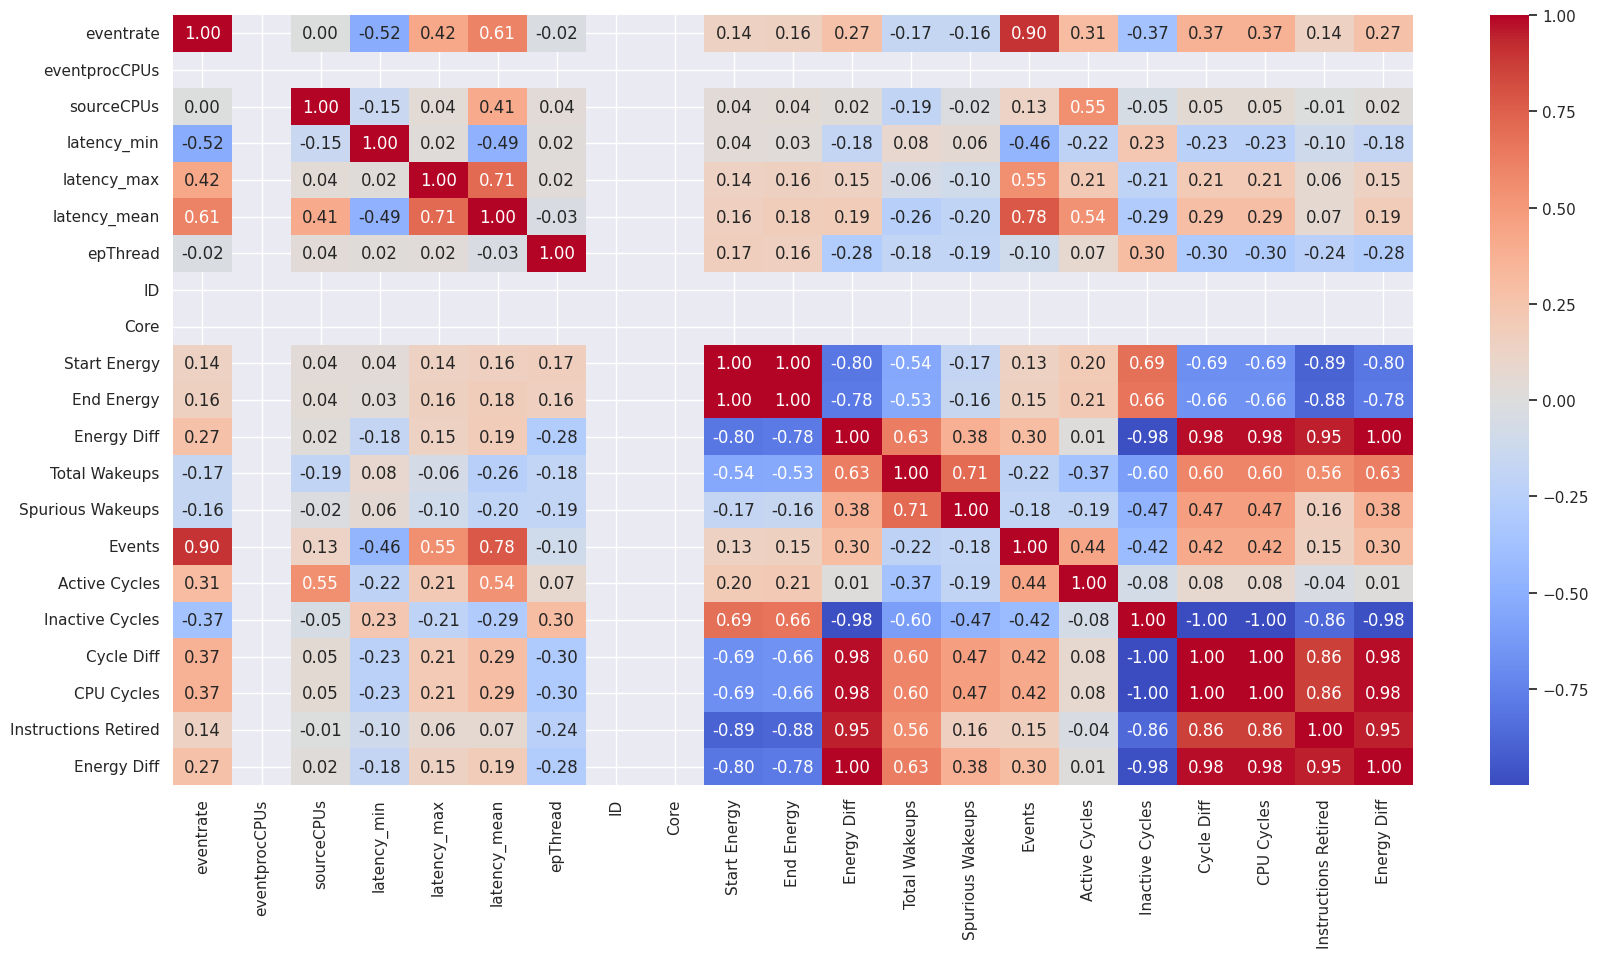

In [6]:
df_used = return_df(bm_perf_output_flat_raw)
output_cols = common_cols + bm_cols + [ENERGY_COLUMN]
corr = df_used[output_cols].corr()

fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')

## Correlations with the HW Monitor Numbers

### HWMON2

#### Power Graphs

##### Choosing subsets of plots

In [7]:
#eventsubset=[10, 100]
#eventsubset=[50000, 100000, 150000]
#eventsubset=[0, 50000]
#sourceCPUsubset=["1", "10", "50"]
bm_var_to_compare = 'Instructions Retired'

##### Relationship between Core 0 Energy and Active Cycles -- Differentiated by Source CPUs

Event Rate subset:  [0, 10, 100, 1000, 100000]
Source CPU subset:  ['1', '10', '50']


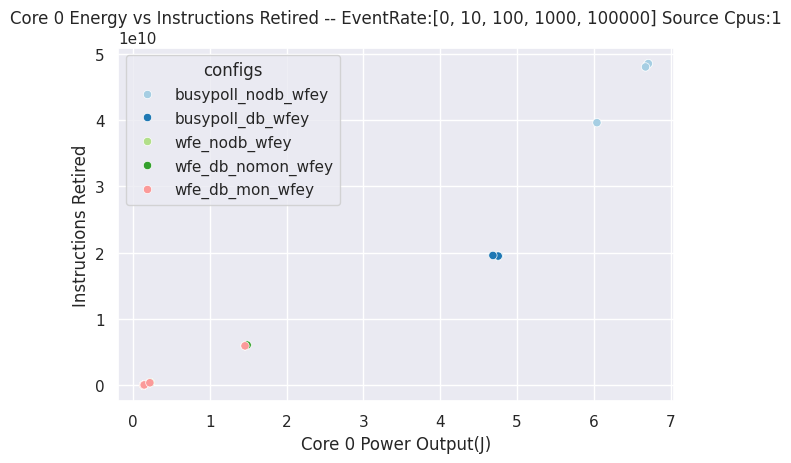

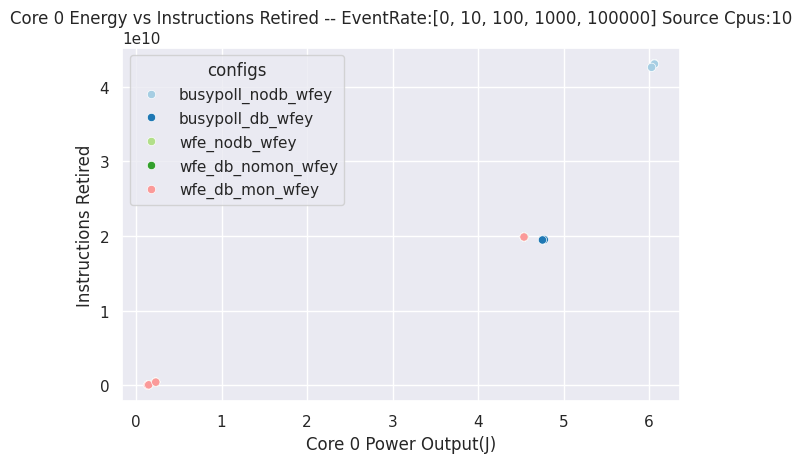

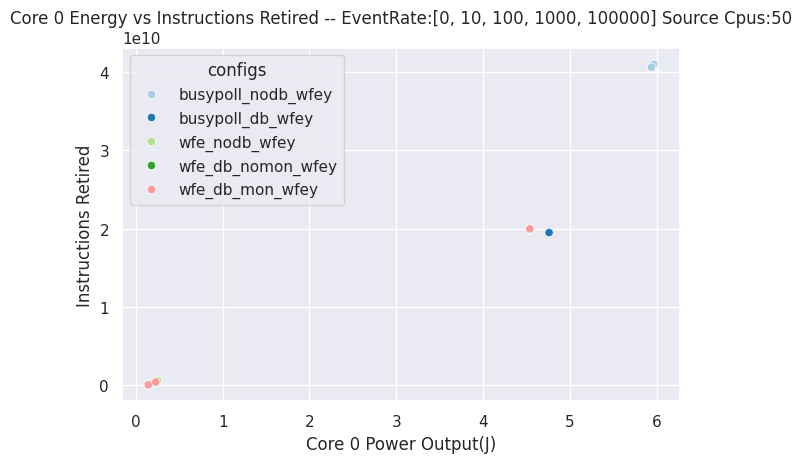

In [8]:
df_used = return_df(bm_perf_output_flat_raw)
config_set = None

#for e in eventsubset:
for sc in sourceCPUsubset:
    plt.figure()
    #config_set = return_config_set(df_used, e, sc)
    config_set = (df_used[(df_used['sourceCPUs'] == sc)])

    #print(config_set[ENERGY_COLUMN])
    
    sns.scatterplot(
        data=config_set.round(2), 
        x=ENERGY_COLUMN,
        y=bm_var_to_compare,
        hue='configs',
    )

    plt.title('Core 0 Energy vs ' + bm_var_to_compare + ' -- EventRate:'+str(eventsubset)+' Source Cpus:'+sc)
    plt.ylabel(bm_var_to_compare)
    plt.xlabel('Core 0 Power Output(J)')
    #plt.ylim(df_used['Active Cycles'].min(),df_used[ENERGY_COLUMN].max())ithelp@bu.edu 
    plt.tight_layout()

##### Relationship between Core 0 Energy and Active Cycles -- Differentiated by Source CPUs

Event Rate subset:  [0, 10, 100, 1000, 100000]
Source CPU subset:  ['1', '10', '50']


<Figure size 640x480 with 0 Axes>

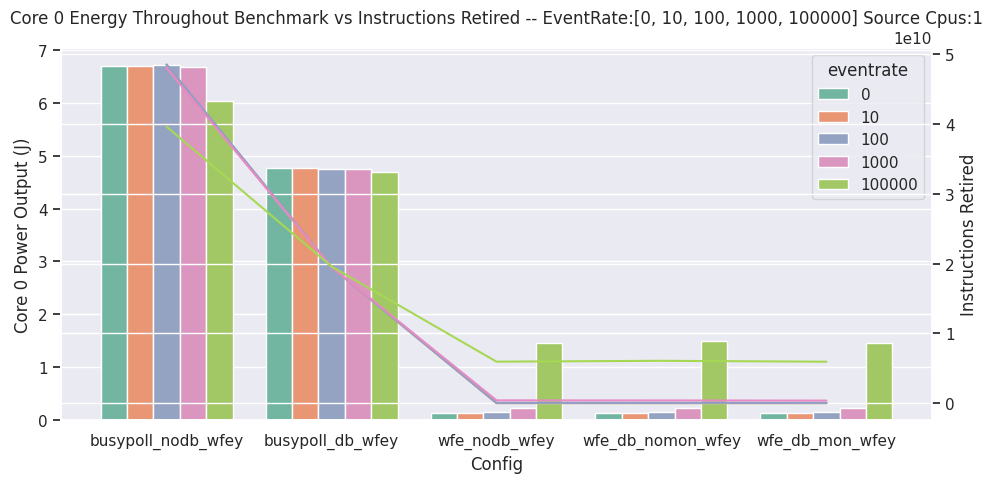

<Figure size 640x480 with 0 Axes>

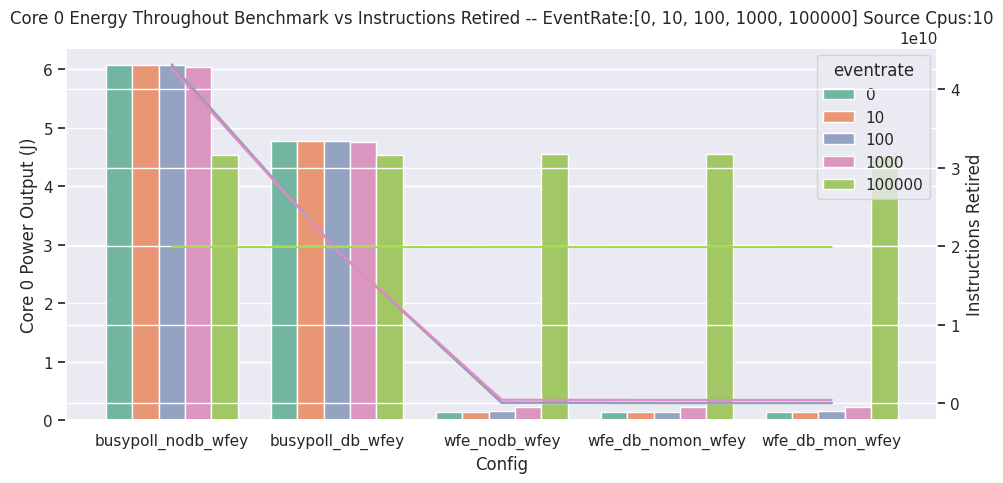

<Figure size 640x480 with 0 Axes>

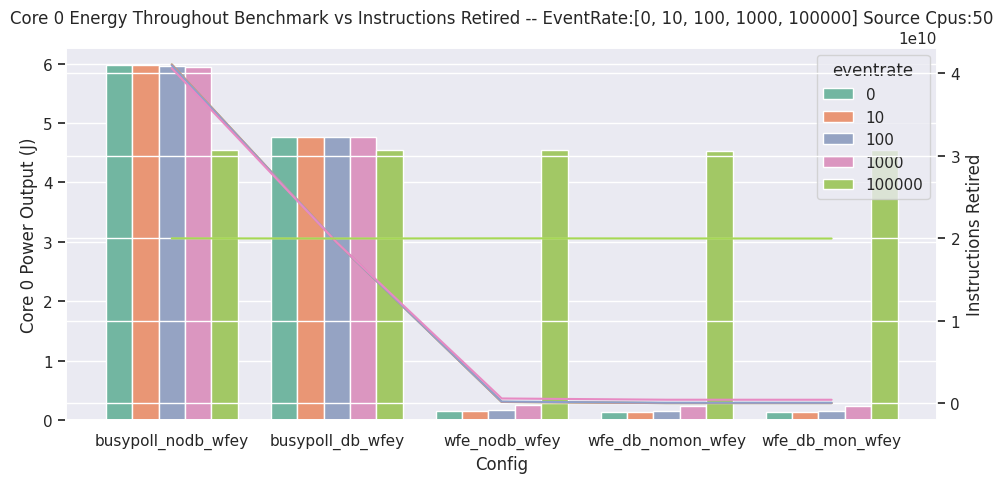

In [24]:
df_used = return_df(bm_perf_output_flat_raw)
config_set = None

for sc in sourceCPUsubset:
    plt.figure()
    #config_set = return_config_set(df_used, e, sc)
    config_set = (df_used[(df_used['sourceCPUs'] == sc)])
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    sns.barplot(
        data=config_set.round(4), 
        x='configs',
        y=ENERGY_COLUMN,
        hue='eventrate',
        palette='Set2',
        errorbar=None,
        ax= ax1
    )

    sns.lineplot(
            data=config_set, 
            x='configs',
            y=bm_var_to_compare,
            hue='eventrate',
            palette='Set2',
            errorbar=None,
            #linestyle='--',
            markers=True,
            ax=ax2,
        legend=False
        )
    
    #print("config set: ", df_used)
    #display(config_set)
    plt.title('Core 0 Energy Throughout Benchmark vs ' + bm_var_to_compare + ' -- EventRate:'+str(eventsubset)+' Source Cpus:'+str(sc))
    ax1.set_xlabel('Config')
    ax1.set_ylabel('Core 0 Power Output (J)')
    ax2.set_ylabel(bm_var_to_compare)
    plt.tight_layout()

##### Relationship between Core 0 Energy and Active Cycles -- Differentiated by Event Rate

Event Rate subset:  [0, 10, 100, 1000, 100000]
Source CPU subset:  ['1', '10', '50']


<Figure size 640x480 with 0 Axes>

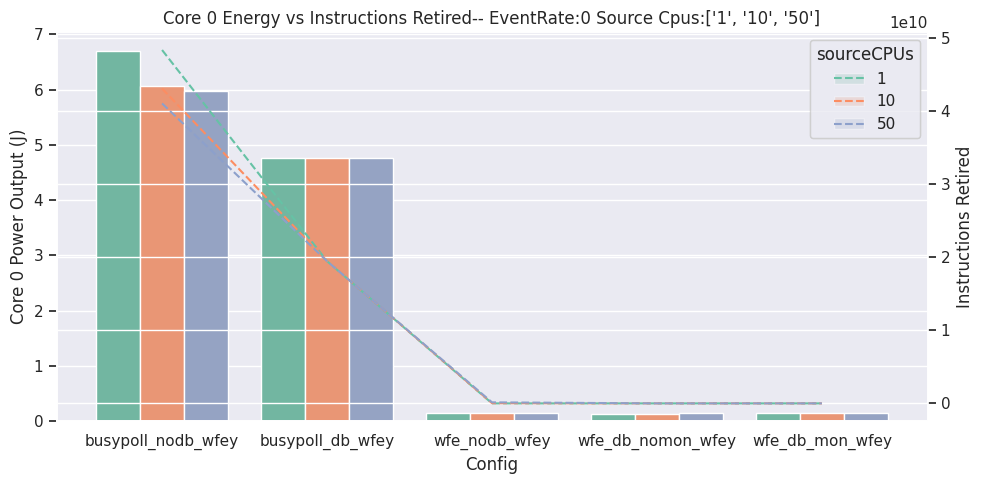

<Figure size 640x480 with 0 Axes>

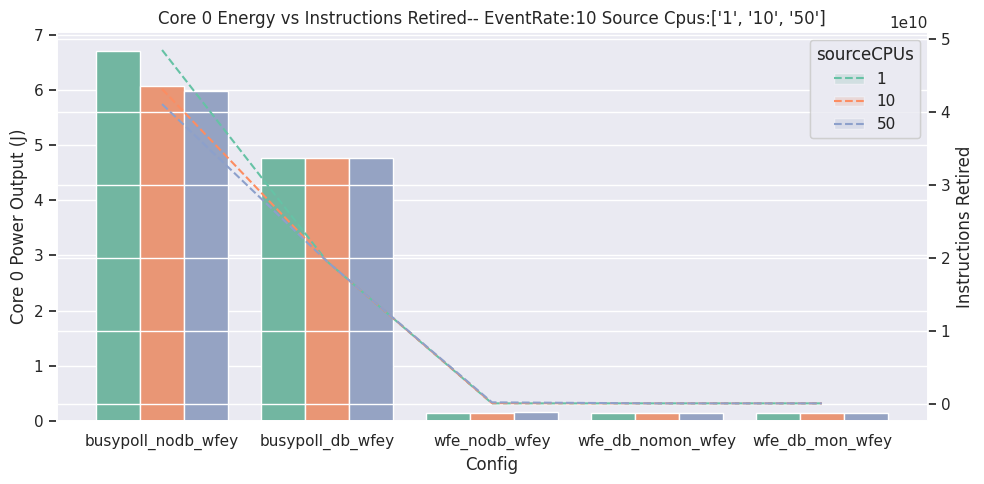

<Figure size 640x480 with 0 Axes>

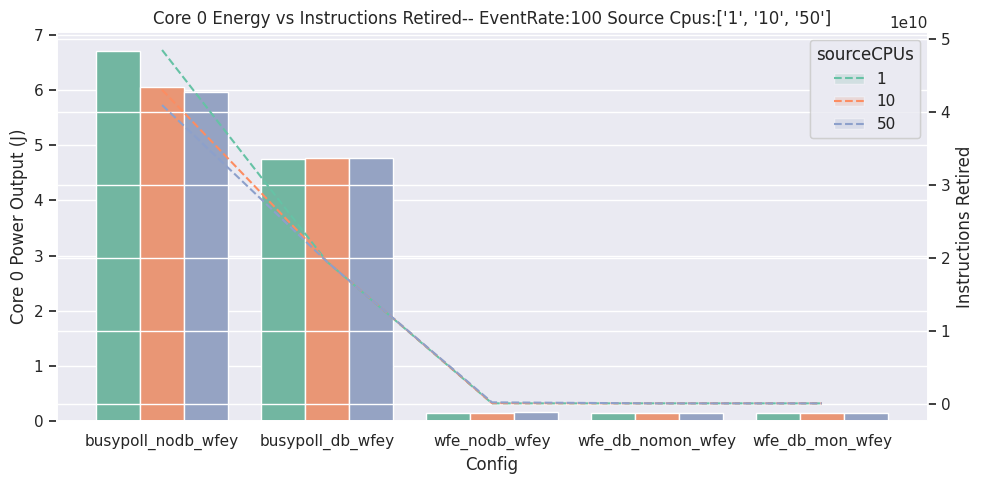

<Figure size 640x480 with 0 Axes>

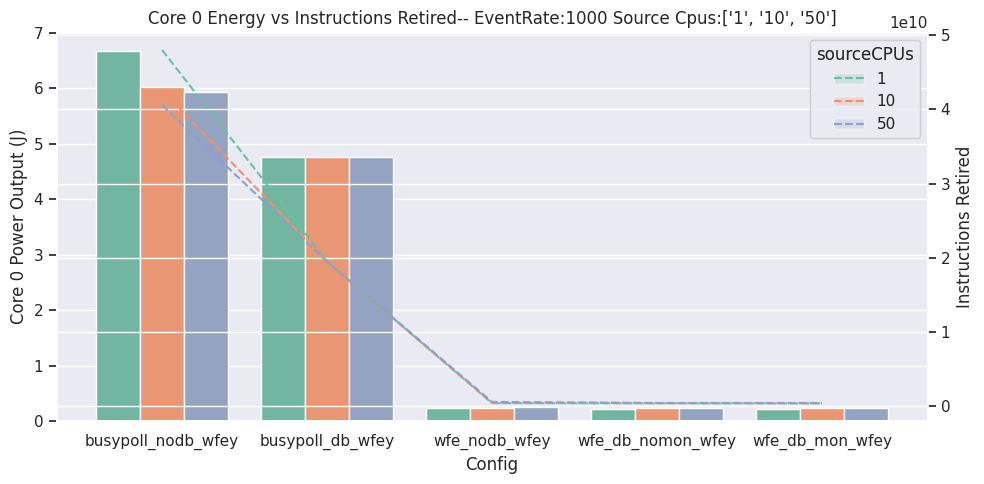

<Figure size 640x480 with 0 Axes>

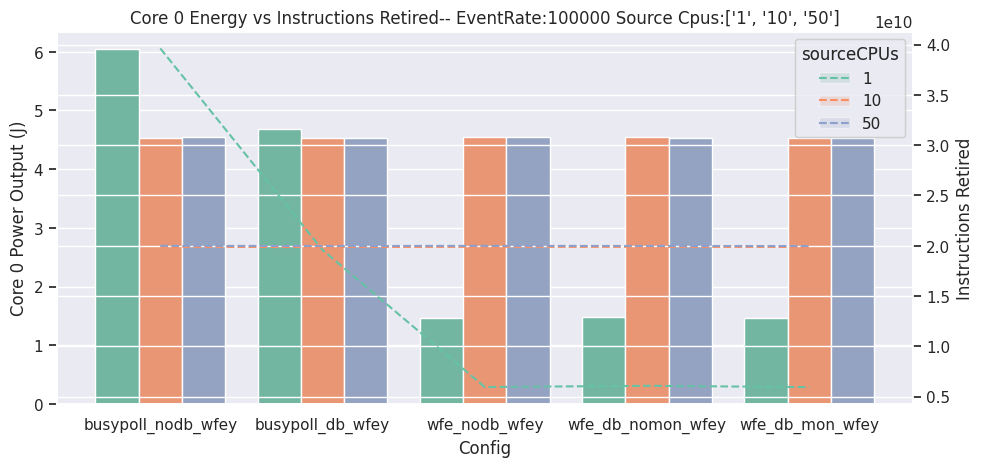

In [10]:
df_used = return_df(bm_perf_output_flat_raw)
config_set = None

for e in eventsubset:
    plt.figure()
    #config_set = return_config_set(df_used, e, sc)
    config_set = (df_used[(df_used['eventrate'] == e)])
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    sns.barplot(
        data=config_set.round(4), 
        x='configs',
        y=ENERGY_COLUMN,
        hue='sourceCPUs',
        palette='Set2',
        errorbar=None,
        ax= ax1
    )

    sns.lineplot(
            data=config_set.round(4), 
            x='configs',
            y=bm_var_to_compare,
            hue='sourceCPUs',
            palette='Set2',
            errorbar=None,
            linestyle='--',
            ax=ax2
        )
    
    #print("config set: ", df_used)
    plt.title('Core 0 Energy vs ' + bm_var_to_compare + '-- EventRate:'+str(e)+' Source Cpus:'+str(sourceCPUsubset))
    ax1.set_xlabel('Config')
    ax1.set_ylabel('Core 0 Power Output (J)')
    ax2.set_ylabel(bm_var_to_compare)
    plt.tight_layout()

##### Relationship between Core 0 Energy and Active Cycles -- Differentiated by Configs Over all Subsets

Event Rate subset:  [0, 10, 100, 1000, 100000]
Source CPU subset:  ['1', '10', '50']


/tmp/ipykernel_551210/732767661.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

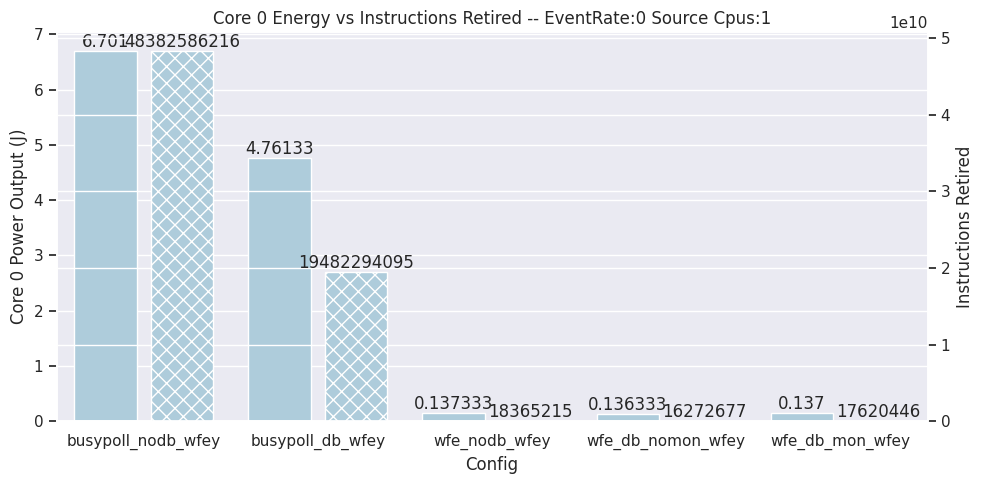

<Figure size 640x480 with 0 Axes>

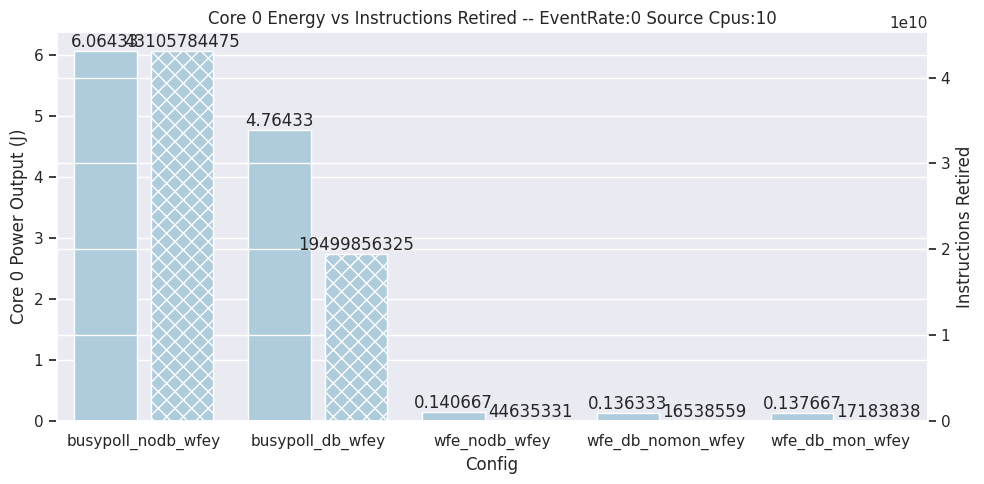

<Figure size 640x480 with 0 Axes>

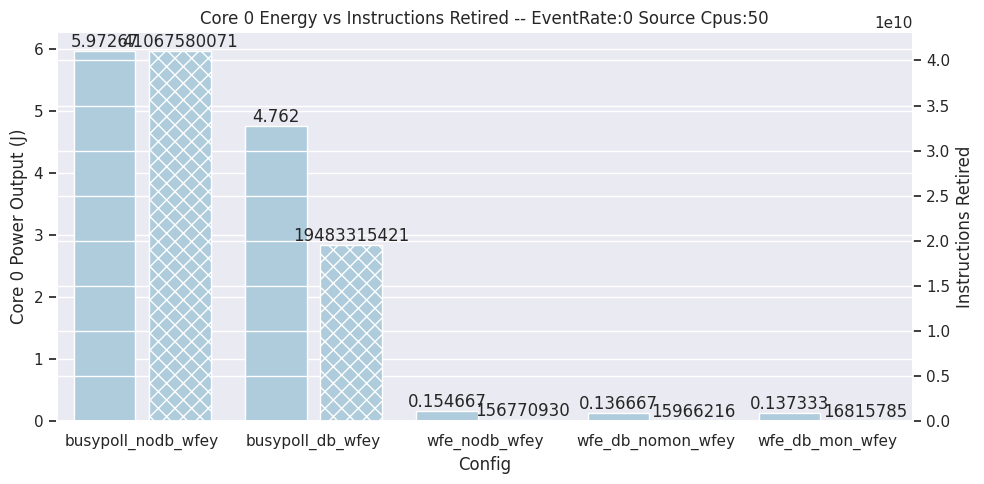

<Figure size 640x480 with 0 Axes>

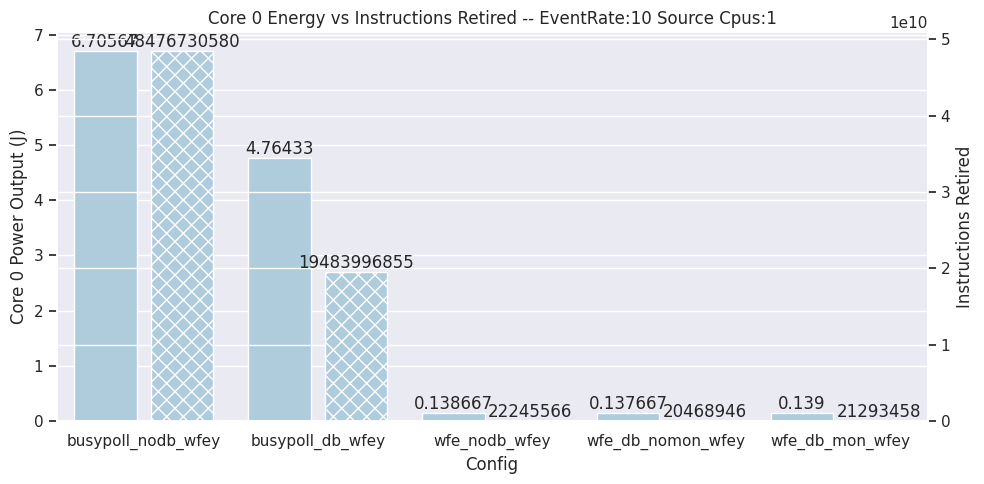

<Figure size 640x480 with 0 Axes>

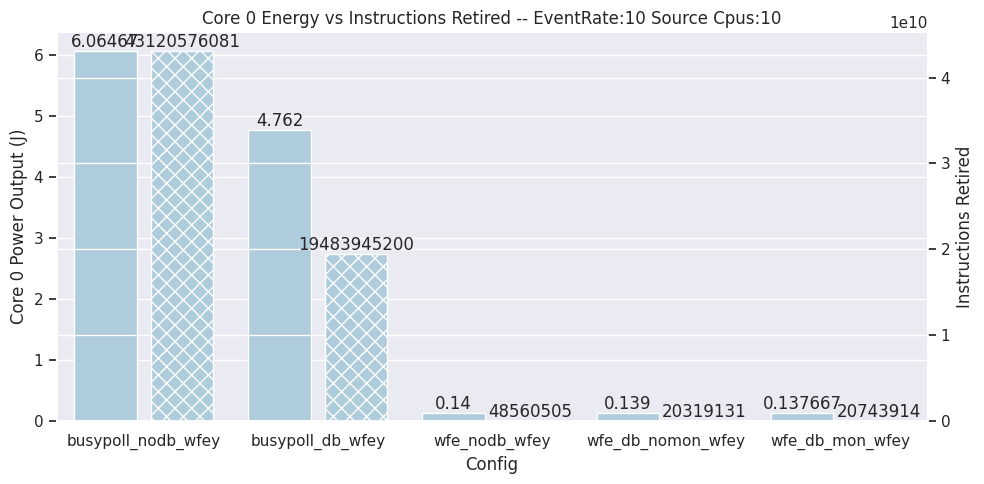

<Figure size 640x480 with 0 Axes>

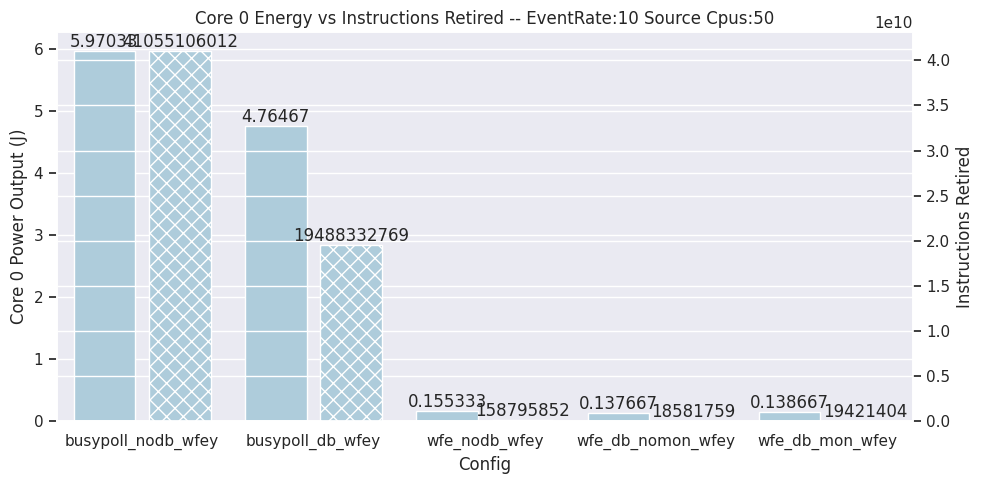

<Figure size 640x480 with 0 Axes>

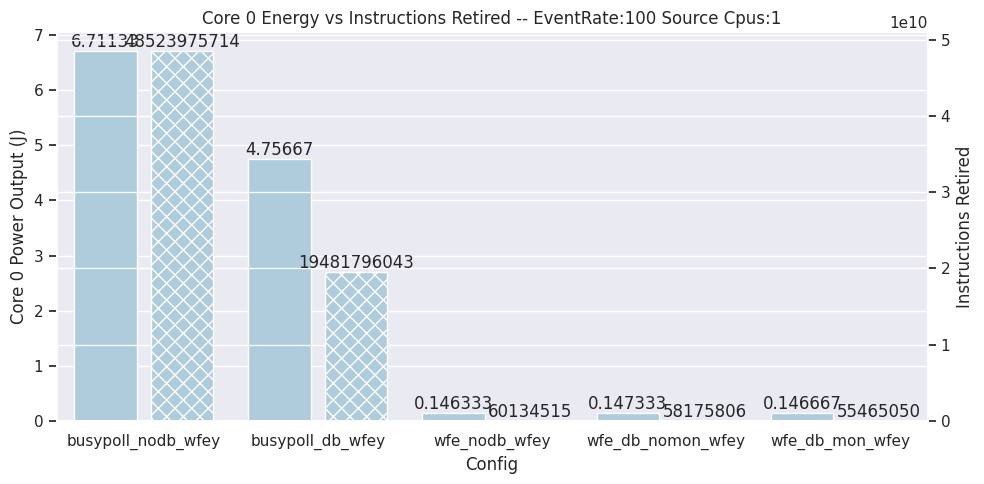

<Figure size 640x480 with 0 Axes>

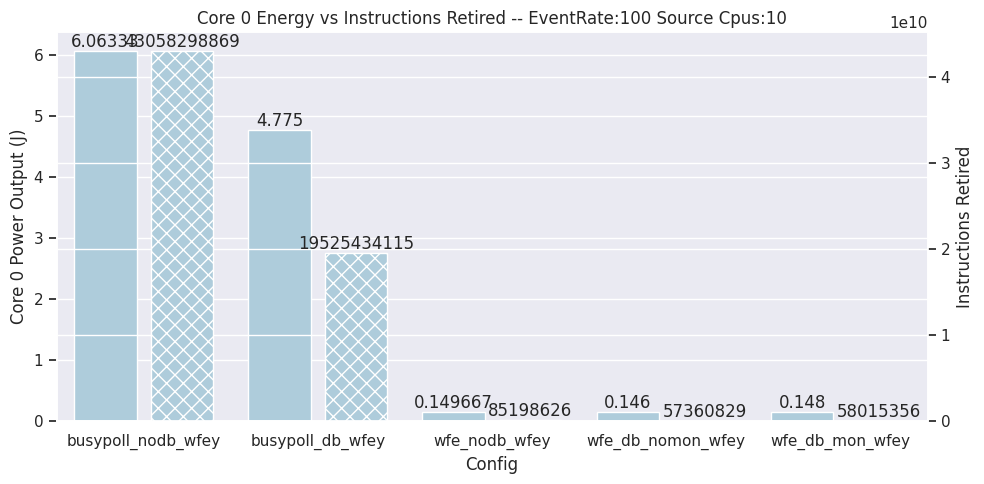

<Figure size 640x480 with 0 Axes>

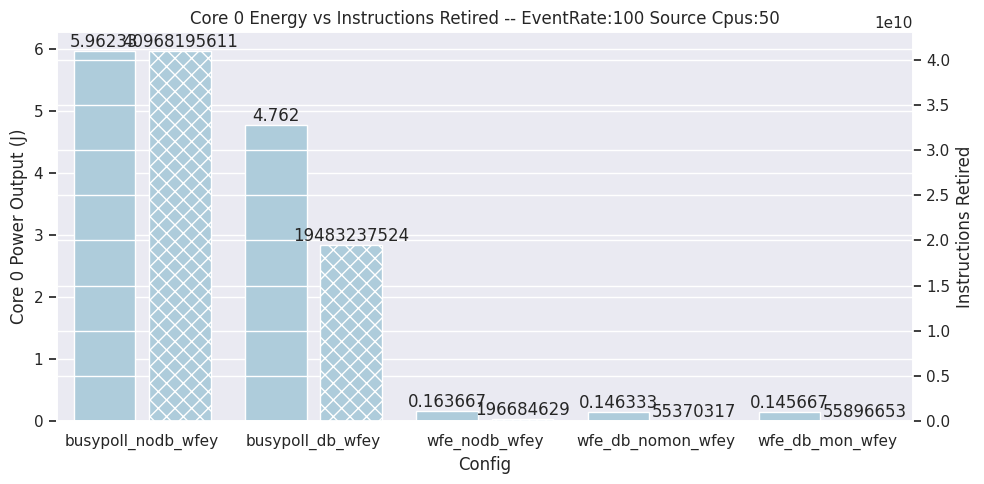

<Figure size 640x480 with 0 Axes>

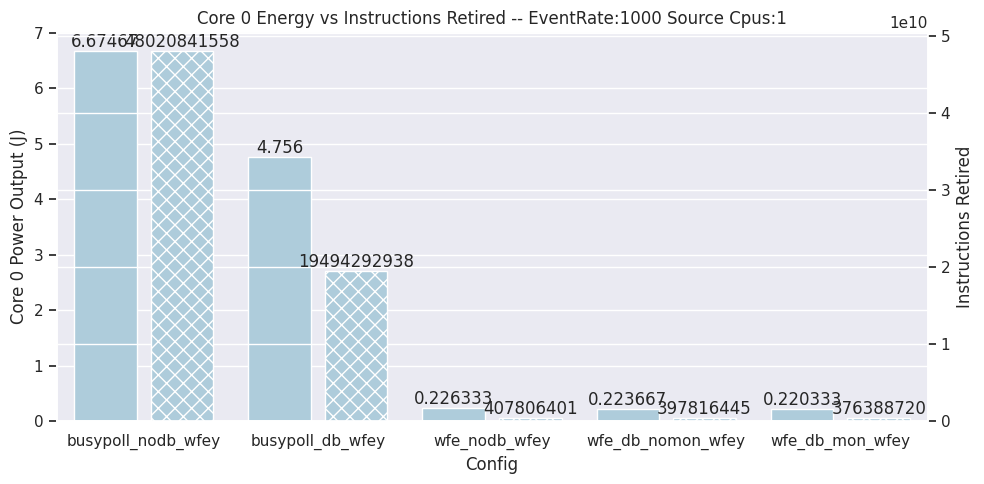

<Figure size 640x480 with 0 Axes>

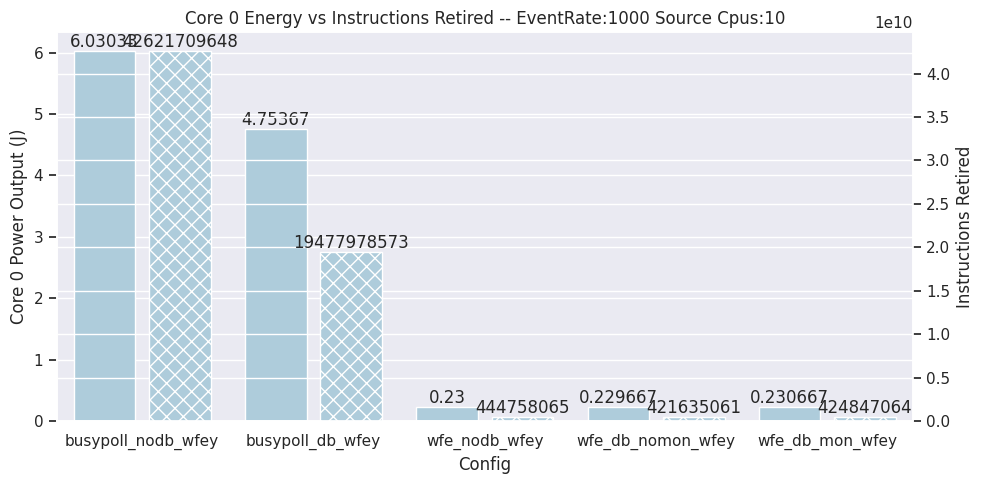

<Figure size 640x480 with 0 Axes>

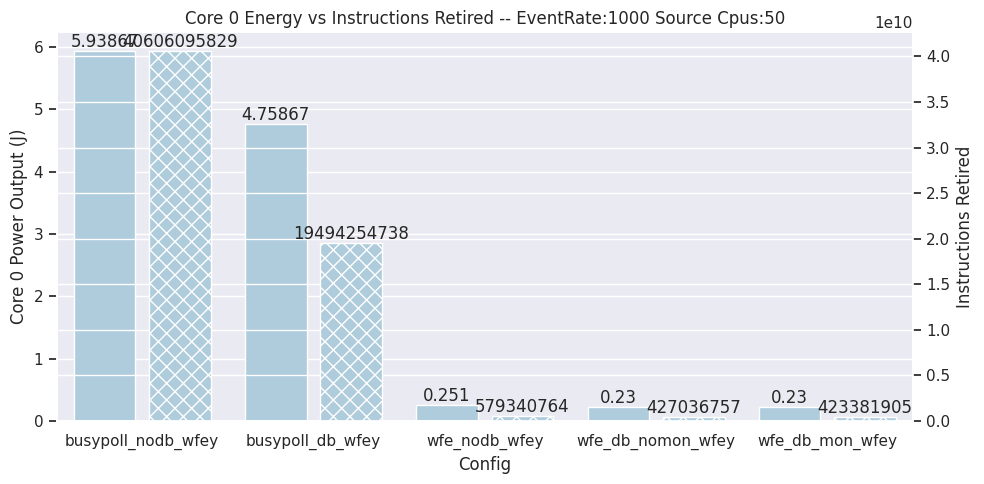

<Figure size 640x480 with 0 Axes>

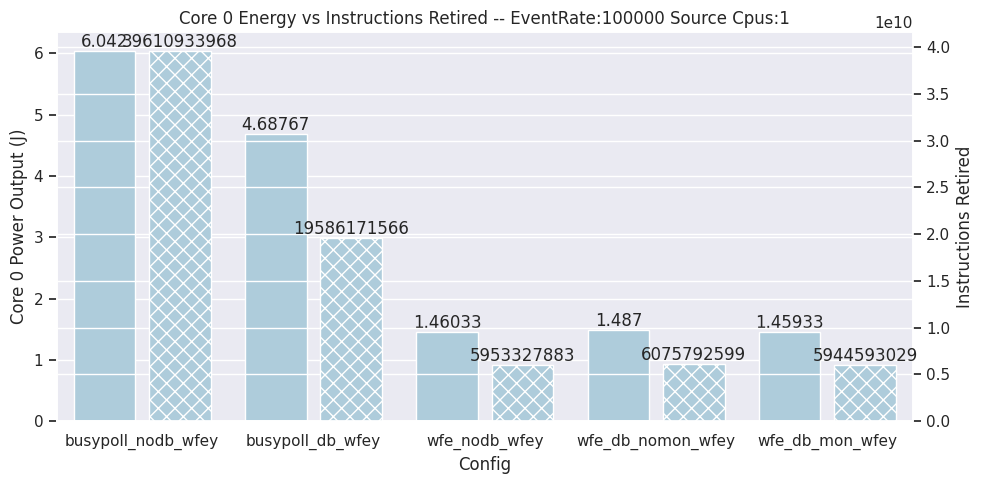

<Figure size 640x480 with 0 Axes>

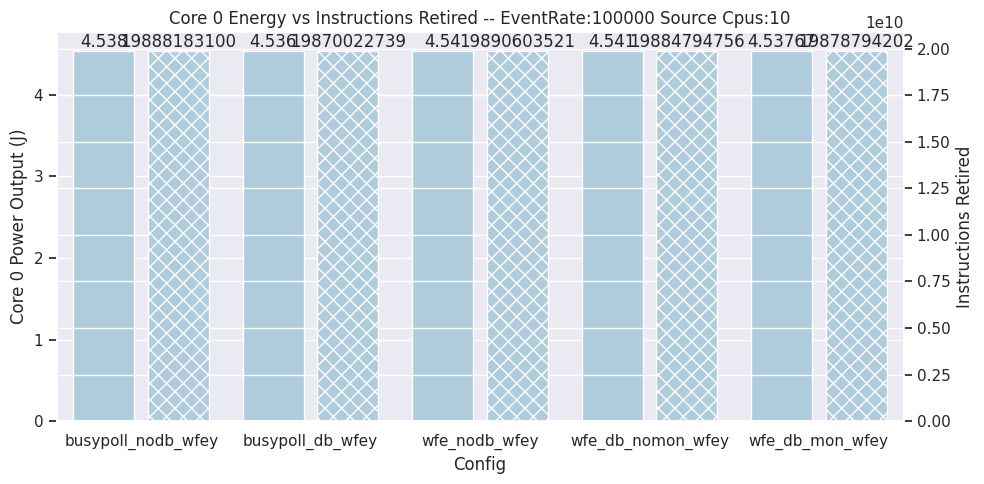

<Figure size 640x480 with 0 Axes>

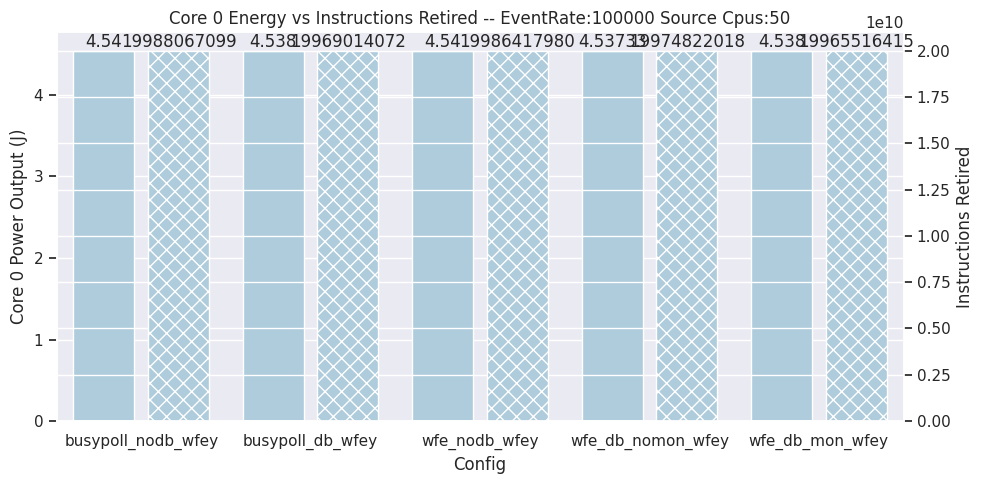

In [11]:
df_used = return_df(bm_perf_output_flat_raw)
config_set = None

#bm_var_to_compare = 'Total Wakeups'

for e in eventsubset:
    for sc in sourceCPUsubset:
        plt.figure()
        config_set = return_config_set(df_used, e, sc)
        #config_set = (df_used[(df_used['sourceCPUs'] == sc)])
        fig, ax1 = plt.subplots(figsize=(10, 5))
        #ax2 = ax1.twinx()
        
        key = str(e)+"_"+str(sc)
        try:
            ax = sns.barplot(
                data=config_set.round(2), 
                x='configs',
                y=ENERGY_COLUMN,
                #hue='configs',
                #palette='Set2',
                errorbar=None
            )
            width_scale = 0.45
            for bar in ax.containers[0]:
                bar.set_width(bar.get_width() * width_scale)
            ax.bar_label(ax.containers[0])

            
            ax2 = ax.twinx()
            ax2 =sns.barplot(
                data=config_set.round(2), 
                x='configs',
                y=bm_var_to_compare,
                #hue='configs',
                #palette='Set2',
                errorbar=None,
                hatch='xx',
                ax=ax2
            )
            for bar in ax2.containers[0]:
                x = bar.get_x()
                w = bar.get_width()
                bar.set_x(x + w * (1- width_scale))
                bar.set_width(w * width_scale)
            ax2.bar_label(ax2.containers[0], fmt='%.0f')
        except Exception as exc:
            print(f"{key}: {exc.__class__.__name__}")
            continue
        #print("config set: ", df_used)
        plt.title('Core 0 Energy vs ' + bm_var_to_compare + ' -- EventRate:'+str(e)+' Source Cpus:'+str(sc))
        ax1.set_xlabel('Config')
        ax1.set_ylabel('Core 0 Power Output (J)')
        ax2.set_ylabel(bm_var_to_compare)
        plt.tight_layout()

##### Mean per EventRate -- Separate

Event Rate subset:  [0, 10, 100, 1000, 100000]
Source CPU subset:  ['1', '10', '50']


/tmp/ipykernel_551210/372624131.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

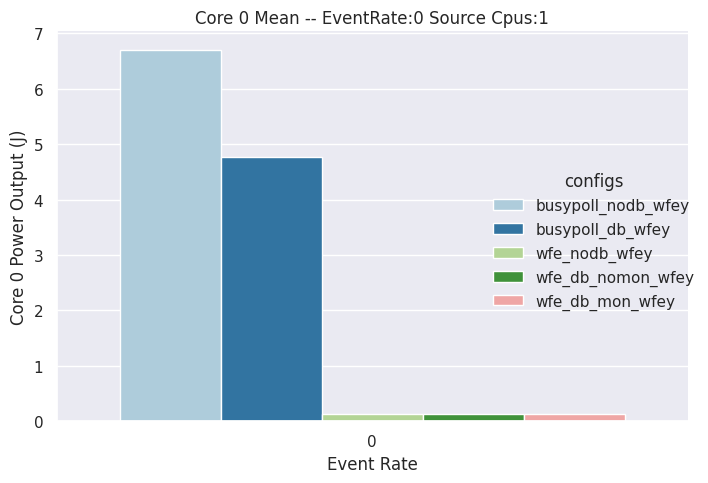

<Figure size 640x480 with 0 Axes>

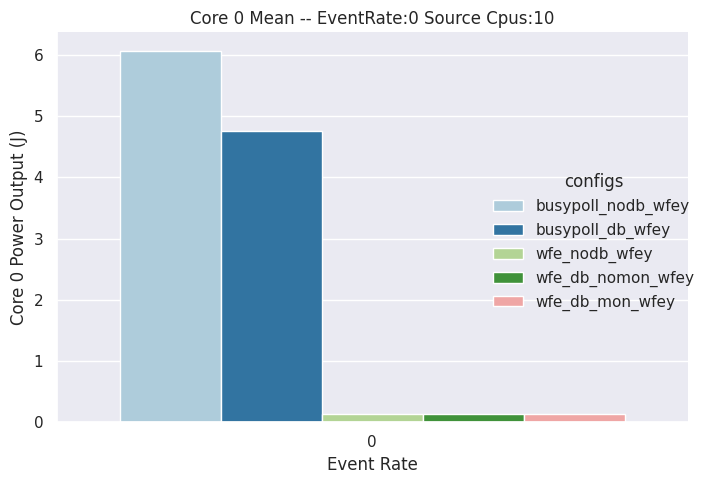

<Figure size 640x480 with 0 Axes>

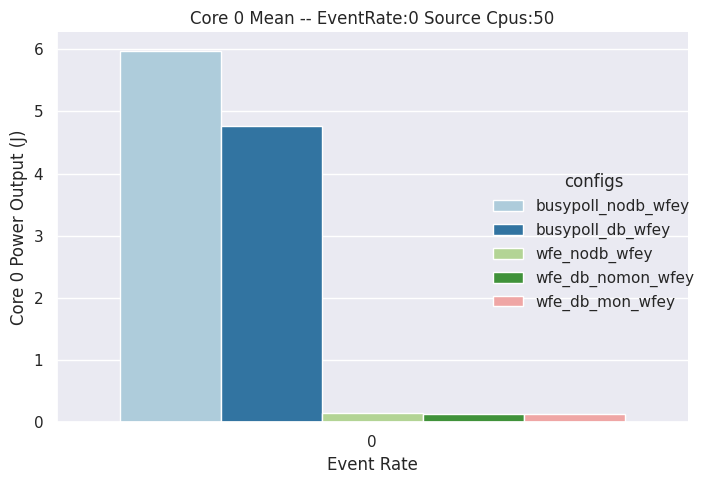

<Figure size 640x480 with 0 Axes>

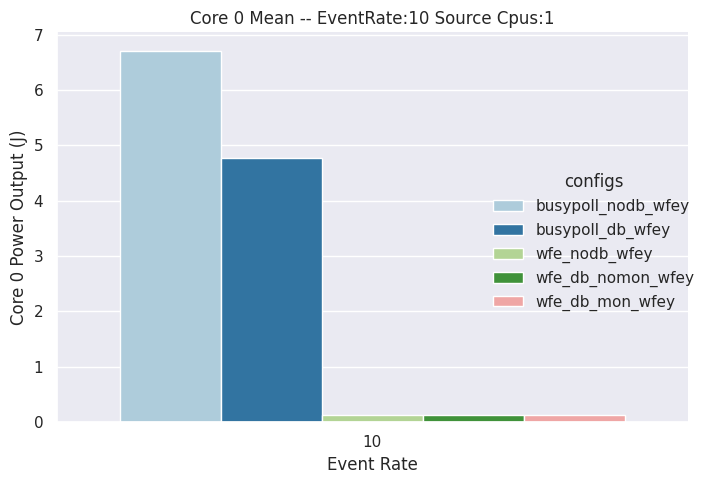

<Figure size 640x480 with 0 Axes>

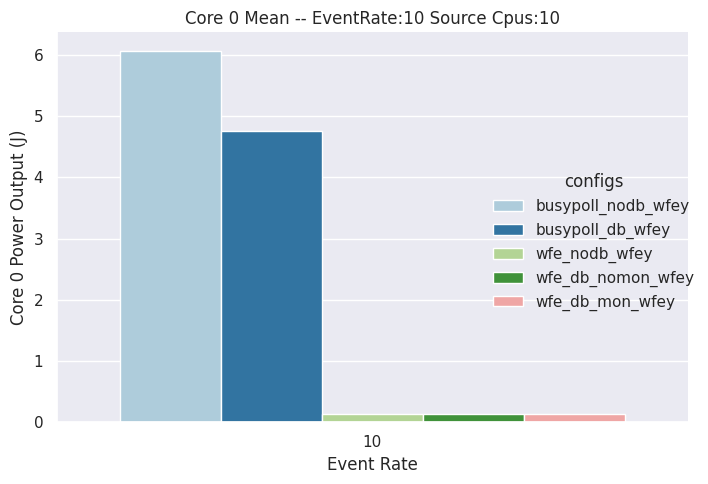

<Figure size 640x480 with 0 Axes>

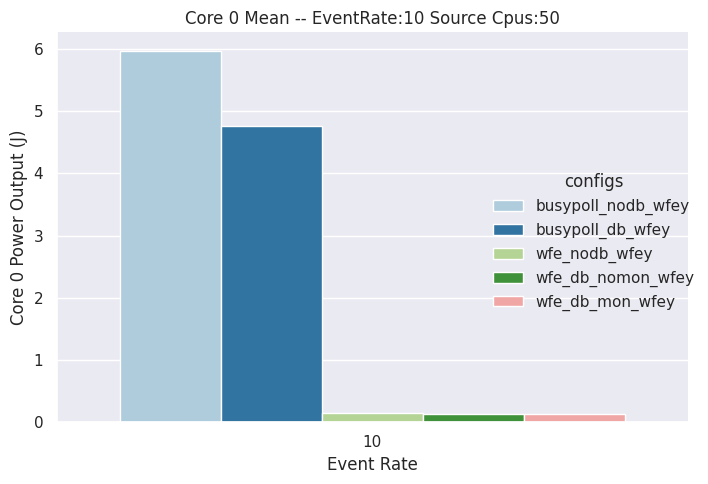

<Figure size 640x480 with 0 Axes>

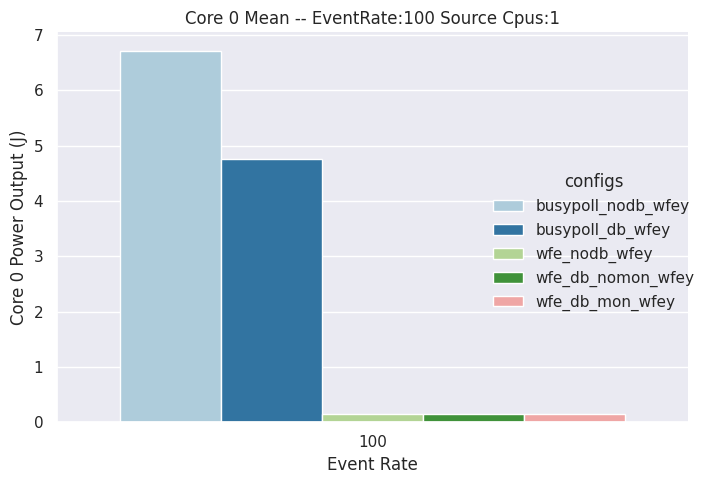

<Figure size 640x480 with 0 Axes>

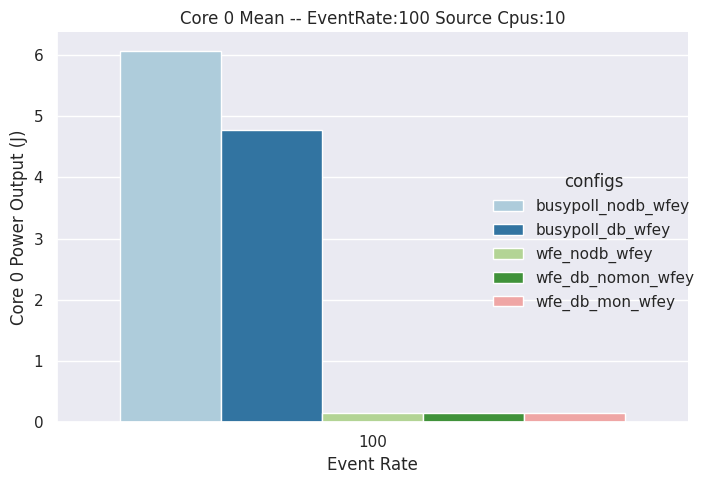

<Figure size 640x480 with 0 Axes>

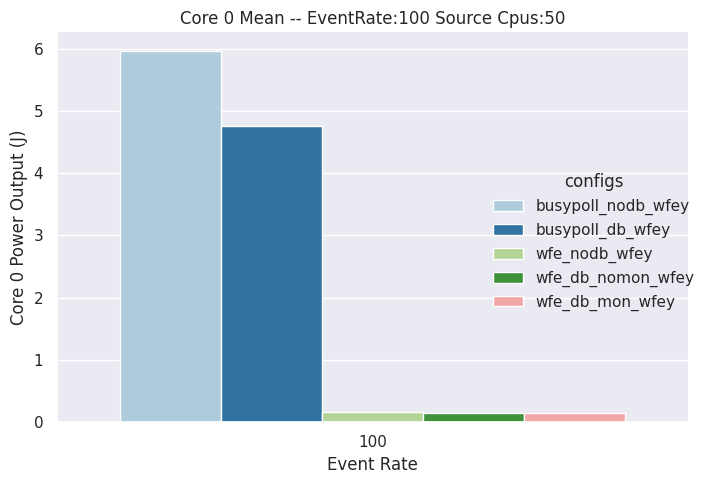

<Figure size 640x480 with 0 Axes>

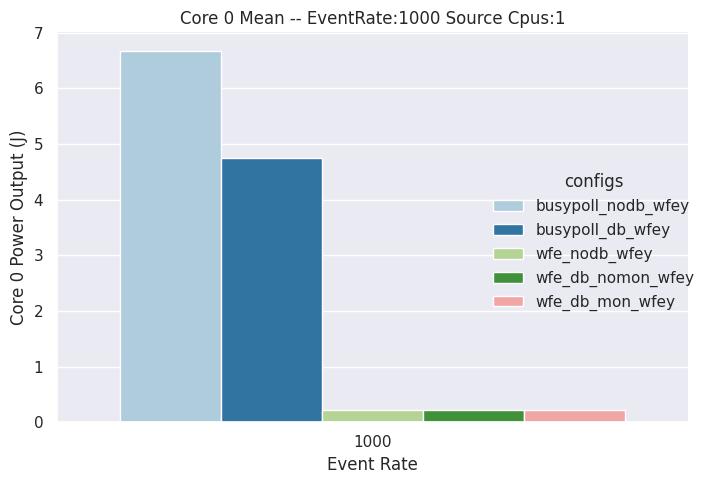

<Figure size 640x480 with 0 Axes>

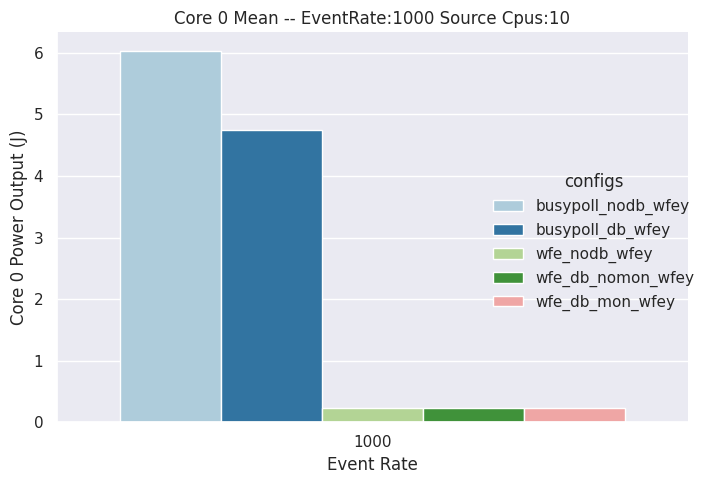

<Figure size 640x480 with 0 Axes>

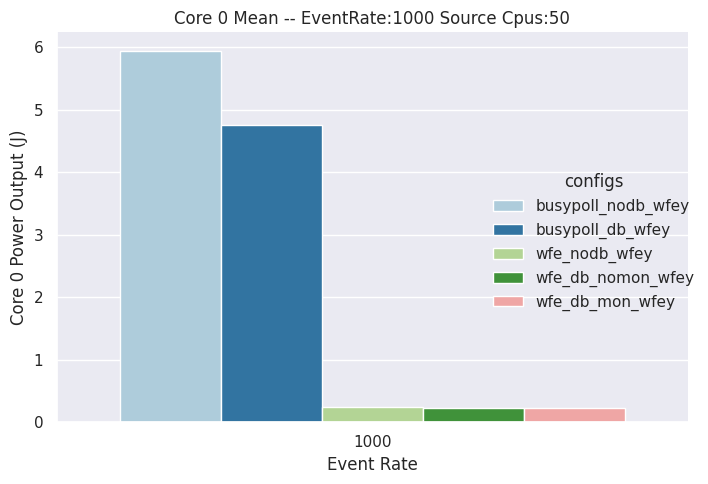

<Figure size 640x480 with 0 Axes>

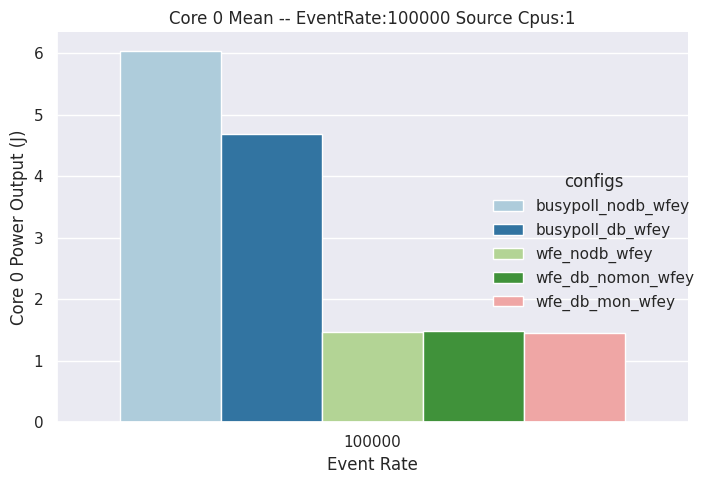

<Figure size 640x480 with 0 Axes>

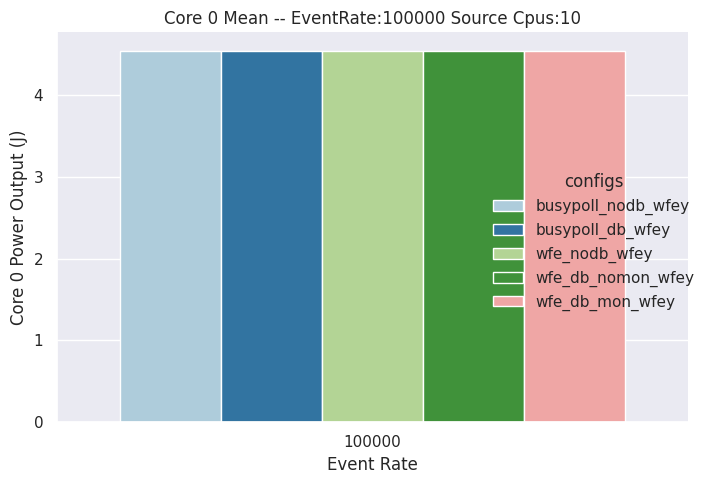

<Figure size 640x480 with 0 Axes>

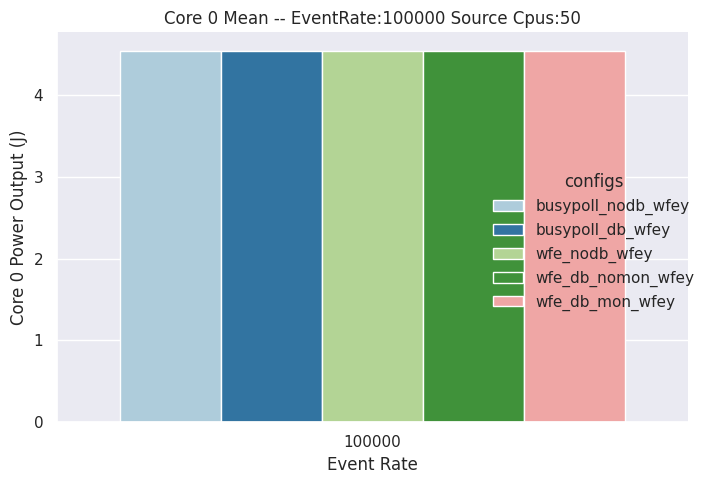

In [12]:
#df_used = return_df(bm_output_raw) #TODO it seems this version doesnt work for bm energy gathering -- because in array -- 
                                    #this has to do with the specifing core problem and needs to be addresssed later
df_used = return_df(bm_perf_output_flat_raw)

config_set = None

for e in eventsubset:
    for sc in sourceCPUsubset:
        plt.figure()
        config_set = return_config_set(df_used, e, sc)


        key = str(e)+"_"+str(sc)
        try:
            g = sns.catplot(
            data=config_set, 
            kind="bar",
            x='eventrate',
            y=ENERGY_COLUMN,
            hue='configs',
            legend=True,
            errorbar=None
            )
        except Exception as exc:
            print(f"{key}: {exc.__class__.__name__}")
            continue

        #sns.scatterplot(data=config_set, x='configs', y='hwmon2_min', hue='configs', legend=False)

        #sns.scatterplot(data=config_set, x='configs', y='hwmon2_max', hue='configs', legend=False)

        #g.fig.get_axes()[0].set_yscale('log')
    
        plt.title('Core 0 Mean -- EventRate:'+str(e)+' Source Cpus:'+sc)
        plt.xlabel('Event Rate')
        plt.ylabel('Core 0 Power Output (J)')
        #plt.ylim(df_used[ENERGY_COLUMN].min(),df_used[ENERGY_COLUMN].max()) # use this to arg set per config
        #plt.ylim(config_set['hwmon2_min'].min(),config_set['hwmon2_max'].max()) # use this to compare the configs per arg set
        plt.tight_layout()

##### Mean per EventRate -- Together

Event Rate subset:  [0, 10, 100, 1000, 100000]
Source CPU subset:  ['1', '10', '50']


<Figure size 640x480 with 0 Axes>

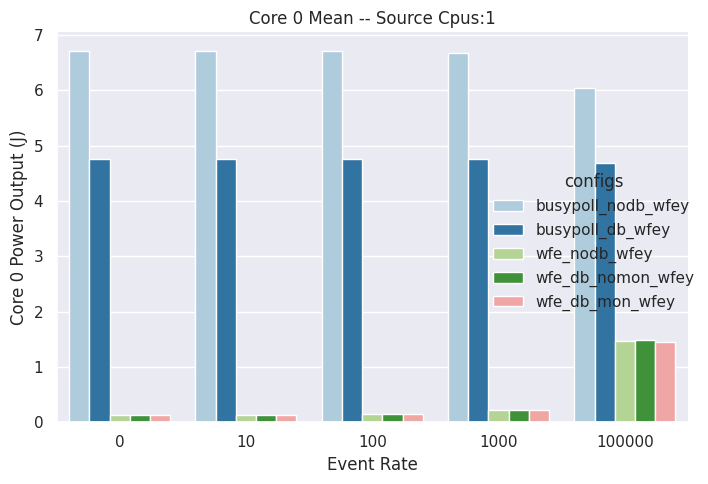

<Figure size 640x480 with 0 Axes>

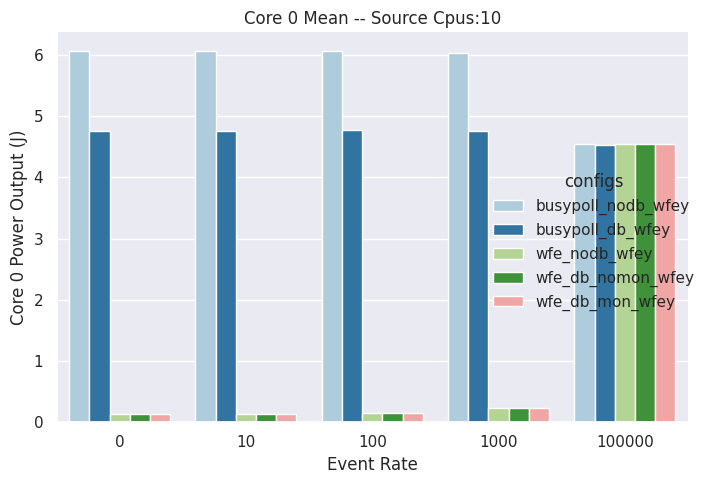

<Figure size 640x480 with 0 Axes>

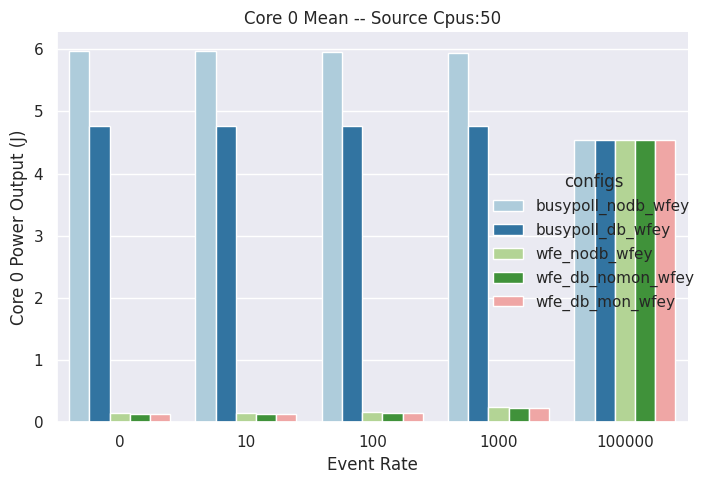

In [13]:
df_used = return_df(bm_perf_output_flat_raw)
config_set = None

for sc in sourceCPUsubset:
    plt.figure()
    config_set = (df_used[(df_used['sourceCPUs'] == sc)])
    
    #key = str(e)+"_"+str(sc)

    g = sns.catplot(
        data=config_set, 
        kind='bar',
        x='eventrate',
        y=ENERGY_COLUMN,
        hue='configs'
    )
    
    #sns.scatterplot(data=config_set, x='configs', y='hwmon2_min', hue='configs', legend=False)
    
    #sns.scatterplot(data=config_set, x='configs', y='hwmon2_max', hue='configs', legend=False)
    
    #g.fig.get_axes()[0].set_yscale('log')
    
    plt.title('Core 0 Mean -- Source Cpus:'+str(sc))
    plt.xlabel('Event Rate')
    plt.ylabel('Core 0 Power Output (J)')
    #plt.ylim(df_used[ENERGY_COLUMN].min(),df_used[ENERGY_COLUMN].max()) # use this to arg set per config
    #plt.ylim(config_set['hwmon2_min'].min(),config_set['hwmon2_max'].max()) # use this to compare the configs per arg set
    plt.tight_layout()

##### Join Plot on Energy and Latency

Event Rate subset:  [0, 10, 100, 1000, 100000]
Source CPU subset:  ['1', '10', '50']


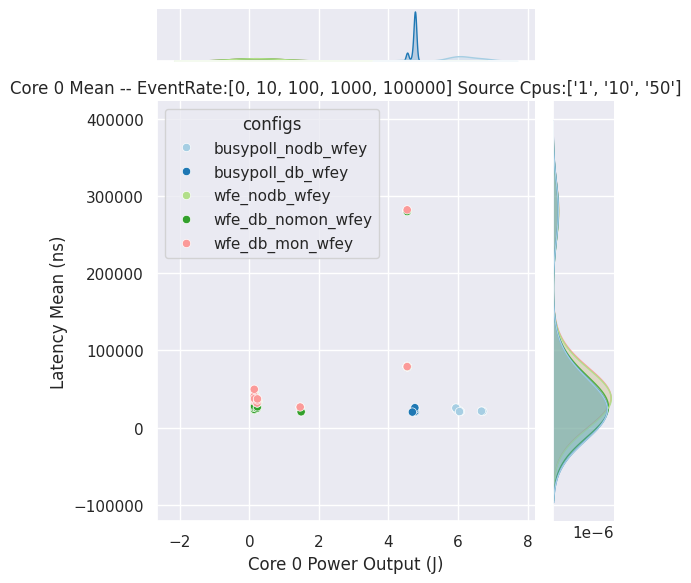

In [14]:
df_used = return_df(bm_perf_output_flat_raw)
config_set = None


try:
    g = sns.jointplot(
        data=df_used.round(2), 
        x=ENERGY_COLUMN,
        y='latency_mean',
        hue='configs',
    )
except Exception as exc:
    print(f"{key}: {exc.__class__.__name__}")

#print("config set: ", df_used)

plt.title('Core 0 Mean -- EventRate:'+str(eventsubset)+' Source Cpus:'+str(sourceCPUsubset))
plt.ylabel('Latency Mean (ns)')
plt.xlabel('Core 0 Power Output (J)')
#plt.ylim(df_used[ENERGY_COLUMN].min(),df_used[ENERGY_COLUMN].max()) # use this to arg set per config
#plt.ylim(config_set['hwmon2_min'].min(),config_set['hwmon2_max'].max()) # use this to compare the configs per arg set
plt.tight_layout()

Event Rate subset:  [0, 10, 100, 1000, 100000]
Source CPU subset:  ['1', '10', '50']


<Figure size 640x480 with 0 Axes>

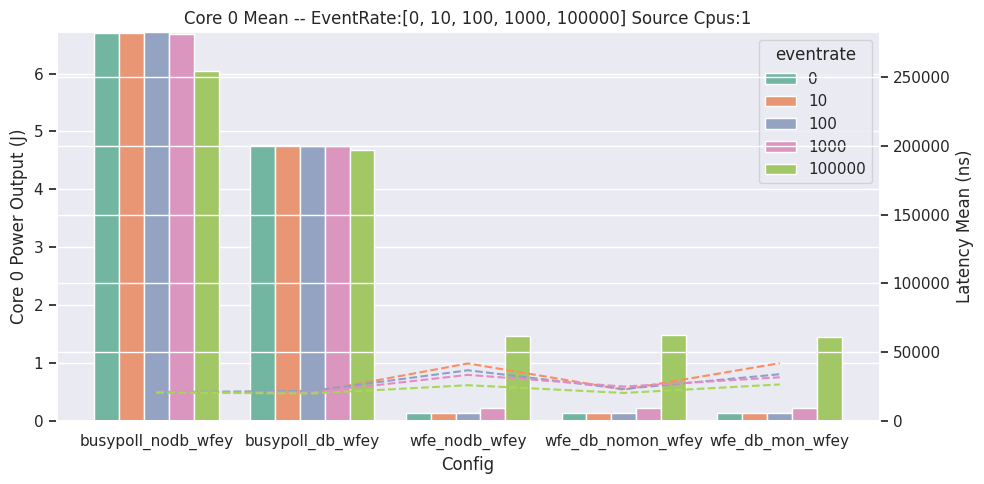

<Figure size 640x480 with 0 Axes>

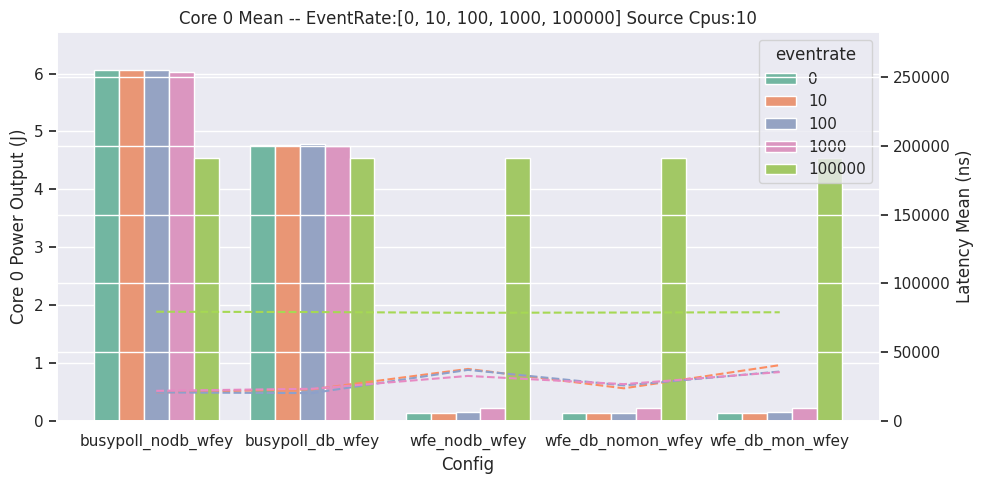

<Figure size 640x480 with 0 Axes>

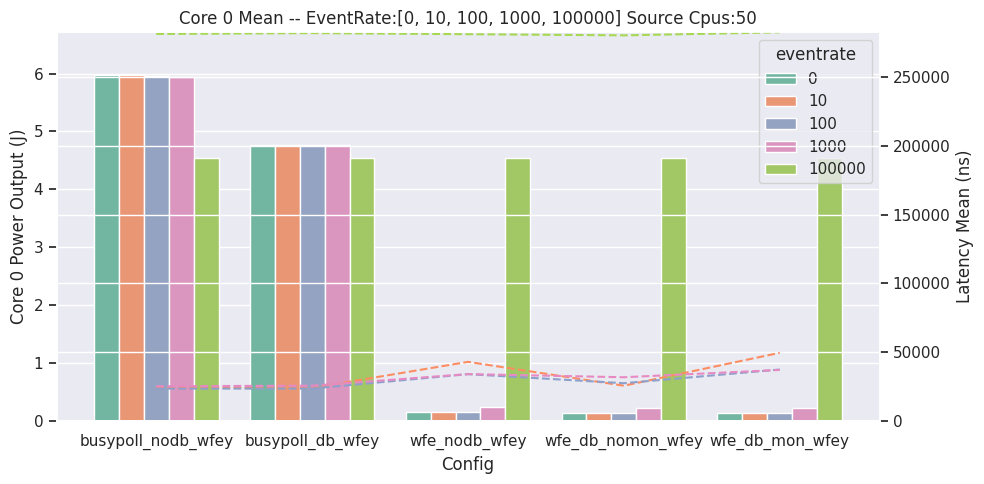

In [15]:
df_used = return_df(bm_perf_output_flat_raw)
config_set = None

for sc in sourceCPUsubset:
    plt.figure()
    #config_set = return_config_set(df_used, e, sc)
    config_set = (df_used[(df_used['sourceCPUs'] == sc)])
    fig, ax1 = plt.subplots(figsize=(10, 5))
    #fig, ax = plt.subplots(figsize=(30, 10))
    ax2 = ax1.twinx()
    
    sns.barplot(
            data=config_set, 
            x='configs',
            y=ENERGY_COLUMN,
            hue='eventrate',
            palette='Set2',
            errorbar=None,
            ax= ax1
        )
    sns.lineplot(
            data=config_set.round(2), 
            x='configs',
            y='latency_mean',
            hue='eventrate',
            palette='Set2',
            errorbar=None,
            linestyle='--',
            ax=ax2,
        legend=False
        )
    
    #print("config set: ", df_used)
    #display(df_used)
    plt.title('Core 0 Mean -- EventRate:'+str(eventsubset)+' Source Cpus:'+str(sc))
    ax1.set_xlabel('Config')
    ax1.set_ylabel('Core 0 Power Output (J)')
    ax2.set_ylabel('Latency Mean (ns)')
    ax1.set_ylim(0,df_used[ENERGY_COLUMN].max()) # use this to arg set per config
    ax2.set_ylim(0,df_used['latency_mean'].max())
    plt.tight_layout()

##### Core 0 Power Benefits -- Differentiated by SourceCPUs

Event Rate subset:  [0, 10, 100, 1000, 100000]
Source CPU subset:  ['1', '10', '50']


<Figure size 640x480 with 0 Axes>

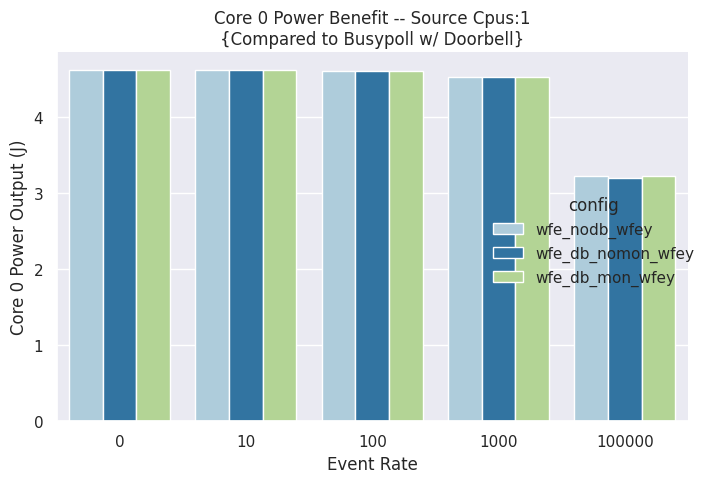

<Figure size 640x480 with 0 Axes>

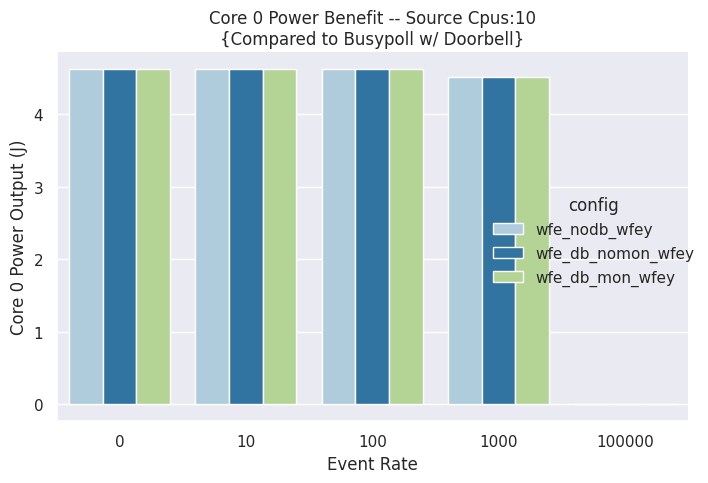

<Figure size 640x480 with 0 Axes>

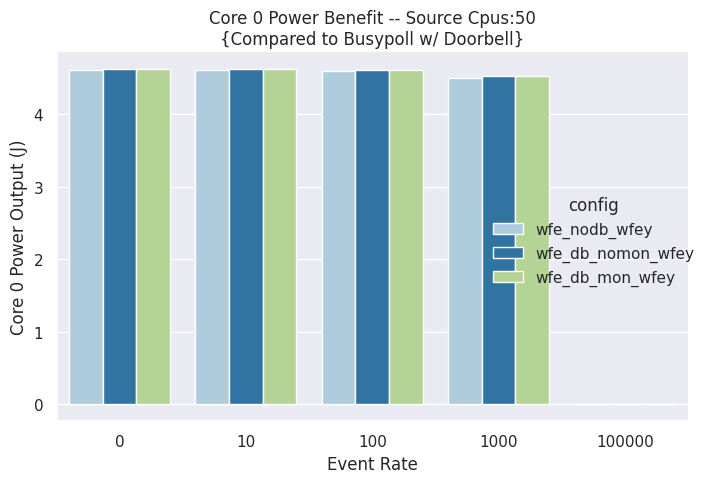

In [16]:
df_used = return_df(bm_output)
config_set = None

tabledf = pd.DataFrame(columns=['eventrate', 'sourceCPUs', 'config', 'diff'])
compare_types = ['wfe_nodb_wfey', 'wfe_db_nomon_wfey', 'wfe_db_mon_wfey']
for e in eventsubset:
    for sc in sourceCPUsubset:
        #plt.figure()
        config_set = return_config_set(df_used, e, sc)
        #config_set = (df_used[(df_used['sourceCPUs'] == sc)])
    
        key = str(e)+"_"+str(1)+"_"+str(sc)

        main_cmp_df = config_set[(config_set['KEY'] == 'busypoll_db_wfey/'+key)]

        for cmptyp in compare_types:
            cmp_df = config_set[(config_set['KEY'] == cmptyp+'/'+key)]
            #print(main_cmp_df[ENERGY_COLUMN])
            #start = main_cmp_df[ENERGY_COLUMN].item()
            #end = cmp_df[ENERGY_COLUMN].item()
            #cmp_diff = start-end
            start = main_cmp_df[ENERGY_COLUMN].tolist()
            end = cmp_df[ENERGY_COLUMN].tolist()
            #print("start:", start, "end:", end)
            cmp_diff = np.subtract(start,end)
            cmp_diff = np.concatenate(cmp_diff).tolist()
            #print(cmp_diff)
            
            tabledf.loc[len(tabledf)] = [e, sc] + [cmptyp] + cmp_diff
#display(tabledf)

for sc in sourceCPUsubset:
    plt.figure()
    config_set = (tabledf[(tabledf['sourceCPUs'] == sc)])

    g = sns.catplot(
        data=config_set, 
        kind='bar',
        x='eventrate',
        y='diff',
        hue='config'
    )
    
    
    plt.title('Core 0 Power Benefit -- Source Cpus:'+str(sc)+'\n{Compared to Busypoll w/ Doorbell}')
    plt.xlabel('Event Rate')
    plt.ylabel('Core 0 Power Output (J)')
    plt.tight_layout()

#### Latency Graphs

##### Choosing subsets of plots

In [17]:
#eventsubset=[10, 100]
#eventsubset=[50000, 100000, 150000]
#sourceCPUsubset=["1", "10", "50"]

## TODO remove 0 but make a copy so doesn't affect graphs above
#eventsubset.remove(0) # no 0 eventrate need because no latency there
df_used = return_df(bm_output_clean)

Event Rate subset:  [0, 10, 100, 1000, 100000]
Source CPU subset:  ['1', '10', '50']


#### Average Latency Numbers across all arg configs for each wfey Config

<Axes: xlabel='eventrate', ylabel='latency_mean'>

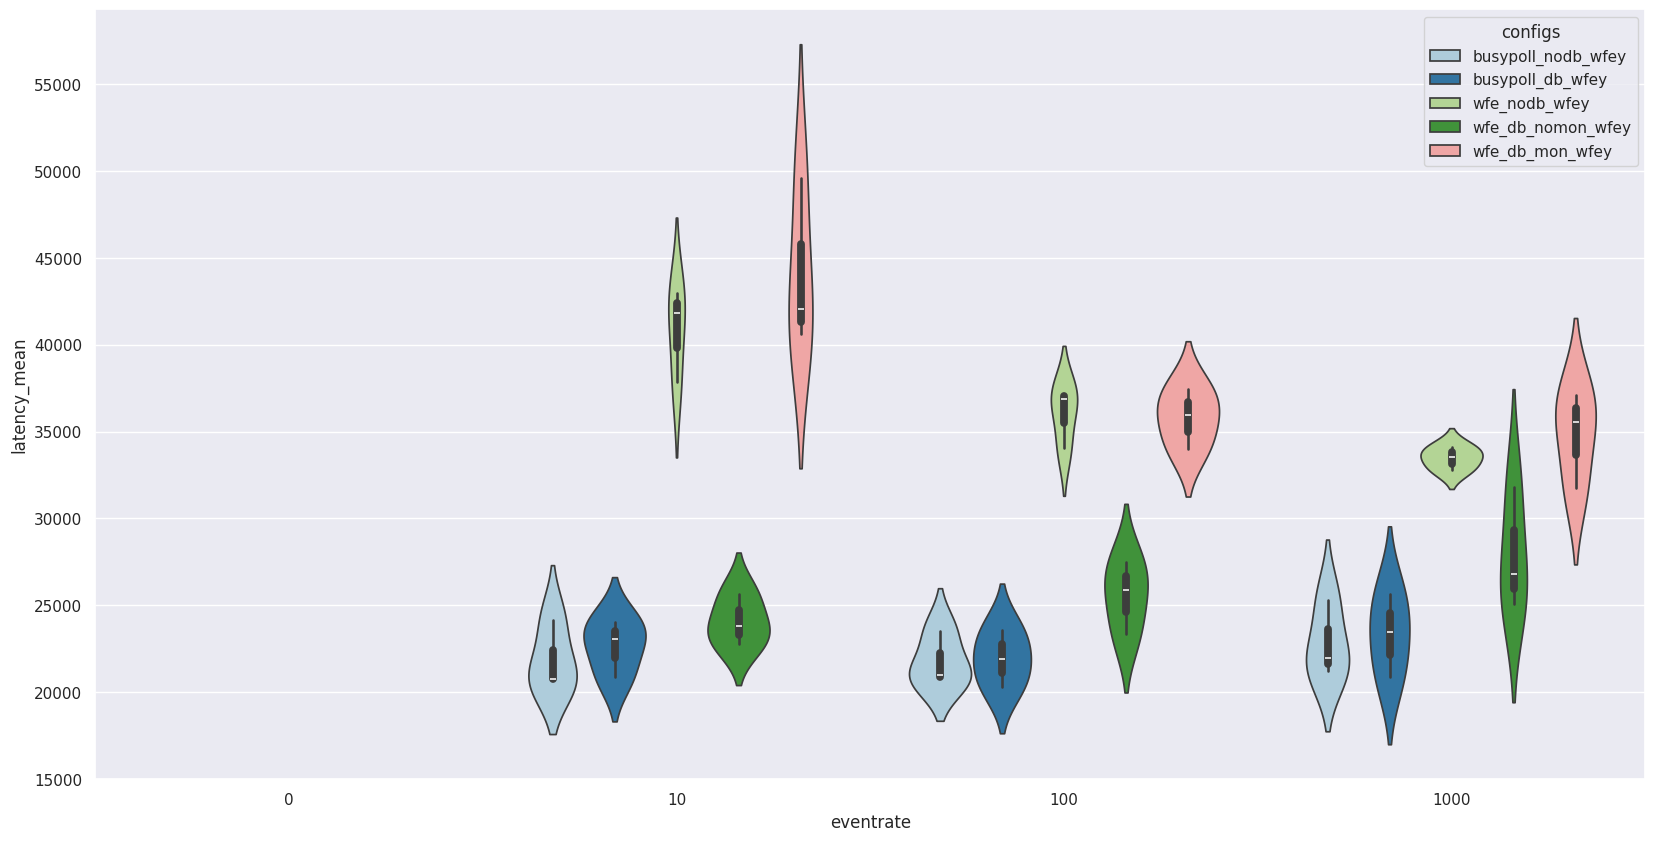

In [18]:
#print(df_used[ ( df_used['eventrate'] != 100000)].loc[:, ['KEY', 'latency_mean']])
new_df =df_used[ ( df_used['eventrate'] != 100000)]
#print(new_df)
fig, ax = plt.subplots(figsize=(20, 10))
sns.violinplot(data=new_df, x='eventrate', y='latency_mean', hue='configs')

<Axes: xlabel='eventrate', ylabel='latency_min'>

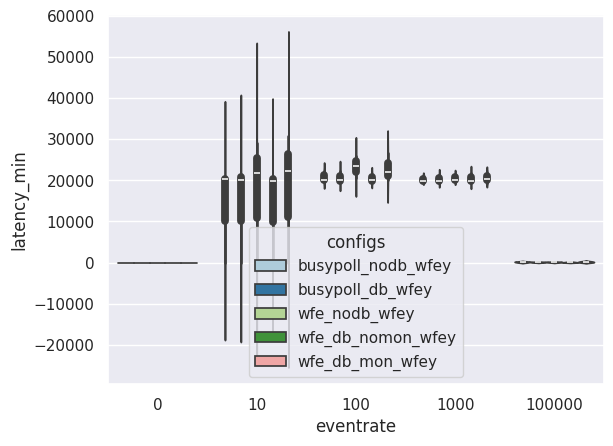

In [19]:
sns.violinplot(data=df_used, x='eventrate', y='latency_min', hue='configs')

<Axes: xlabel='eventrate', ylabel='latency_max'>

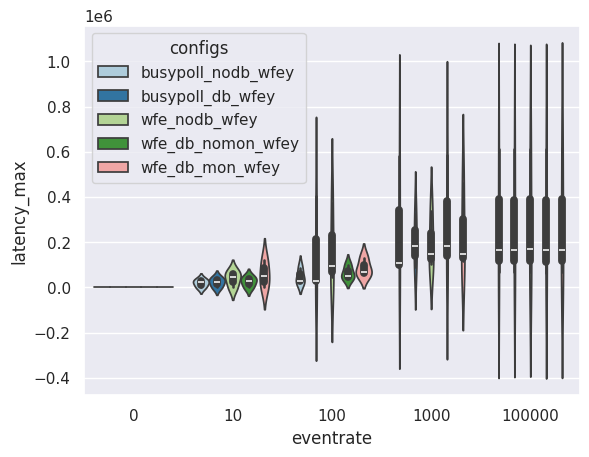

In [20]:
sns.violinplot(data=df_used, x='eventrate', y='latency_max', hue='configs')

##### Min/Max/Mean per Config

Event Rate subset:  [0, 10, 100, 1000, 100000]
Source CPU subset:  ['1', '10', '50']


<Figure size 640x480 with 0 Axes>

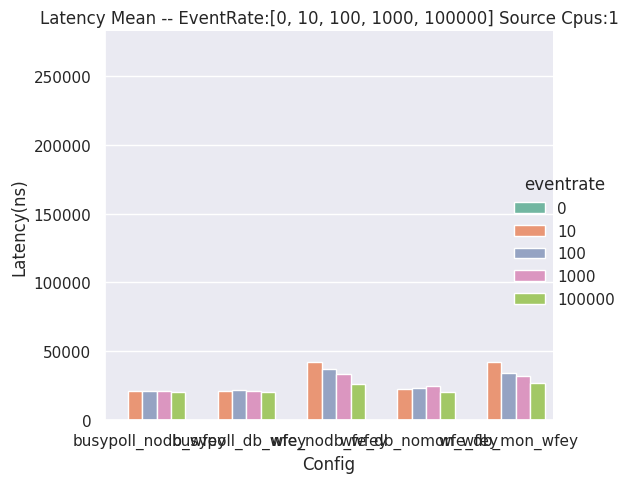

<Figure size 640x480 with 0 Axes>

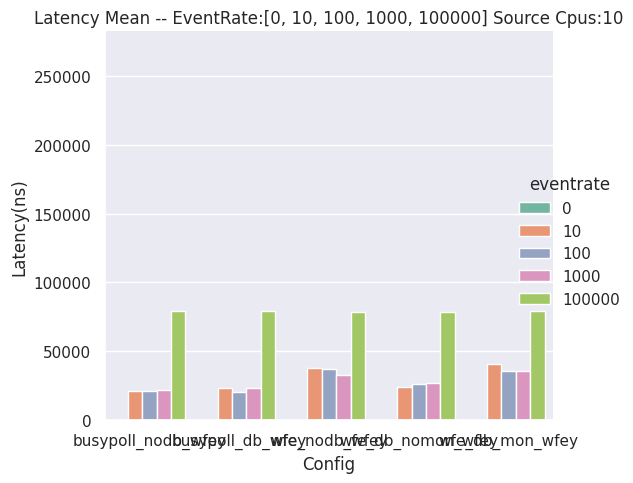

<Figure size 640x480 with 0 Axes>

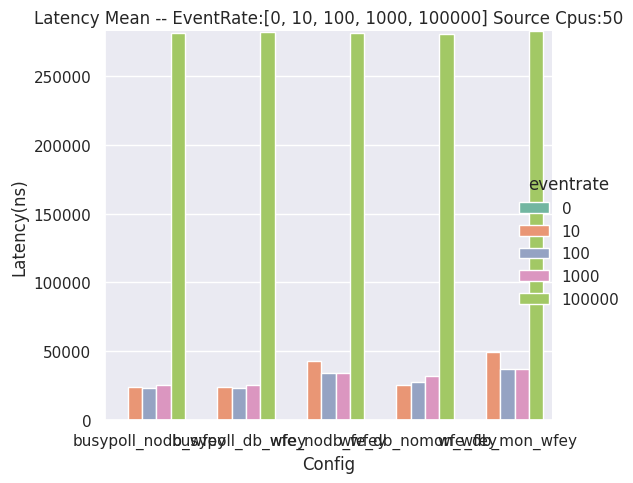

In [21]:
df_used = return_df(bm_perf_output_flat_raw)
config_set = None

for sc in sourceCPUsubset:
    plt.figure()
    #config_set = return_config_set(df_used, e, sc)
    config_set = (df_used[(df_used['sourceCPUs'] == sc)])

    key = str(e)+"_"+str(sc)
    try:
        g = sns.catplot(
        data=config_set, 
        kind="bar",
        x='configs',
        y='latency_mean',
        hue='eventrate',
            palette='Set2',
        legend=True,
        errorbar=None
        )
    except Exception as exc:
        print(f"{key}: {exc.__class__.__name__}")
        continue

    #sns.scatterplot(data=config_set,x='configs',y='latency_min',hue='configs',legend=False)
    #sns.scatterplot(data=config_set,x='configs',y='latency_max',hue='configs',legend=False)

    plt.title('Latency Mean -- EventRate:'+str(eventsubset)+' Source Cpus:'+sc)
    plt.xlabel('Config')
    plt.ylabel('Latency(ns)')
    #plt.ylim(0,config_set['latency_mean'].max())
    plt.ylim(0,df_used['latency_mean'].max())
    plt.tight_layout()